# Cross-Validation Playground

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

https://dev.to/balapriya/cross-validation-and-hyperparameter-search-in-scikit-learn-a-complete-guide-5ed8

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
)

from helpers.display import disp_df, plot_feature_statistics

## Iris dataset

In [4]:
# fetch dataset
data = load_iris(as_frame=True)
data.frame.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
disp_df(data.frame)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [6]:
X = data.frame.drop(columns="target")
y = data.frame.target
X.shape, y.shape

((150, 4), (150,))

In [7]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


(<Figure size 800x600 with 8 Axes>,
 array([[<Axes: title={'center': 'Histogram of sepal length (cm)'}, xlabel='sepal length (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of sepal length (cm)'}, xlabel='sepal length (cm)'>],
        [<Axes: title={'center': 'Histogram of sepal width (cm)'}, xlabel='sepal width (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of sepal width (cm)'}, xlabel='sepal width (cm)'>],
        [<Axes: title={'center': 'Histogram of petal length (cm)'}, xlabel='petal length (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of petal length (cm)'}, xlabel='petal length (cm)'>],
        [<Axes: title={'center': 'Histogram of petal width (cm)'}, xlabel='petal width (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of petal width (cm)'}, xlabel='petal width (cm)'>]],
       dtype=object))

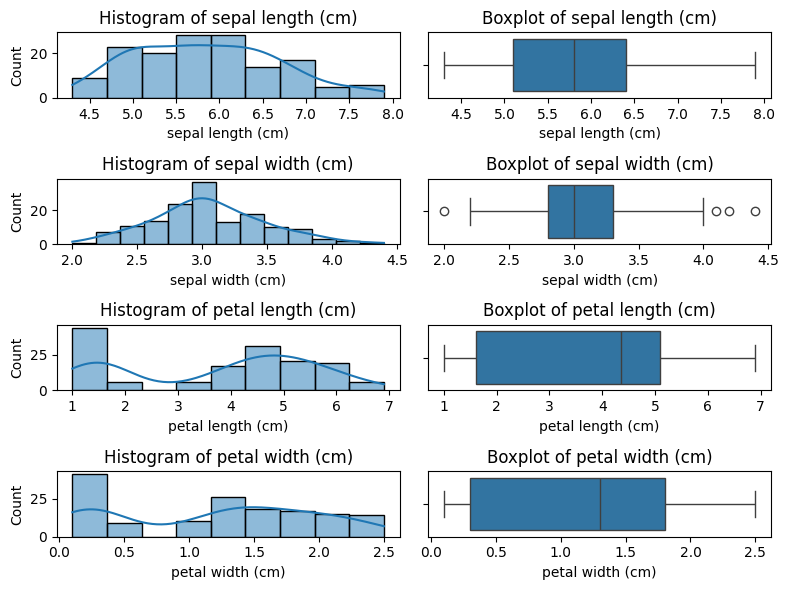

In [8]:
plot_feature_statistics(X, X.columns, line=False)

In [9]:
# after StandardScaler, mean = 0 and std = 1 and range varies
# SENSITIVE TO OUTLIERS
scaler = StandardScaler(
    with_mean=True,  # center the data before scaling
    with_std=True,  # scale the data to unit variance
)
scaler.fit(X)
X_tr = scaler.transform(X)

In [10]:
X_tr = pd.DataFrame(X_tr, columns=X.columns)

In [11]:
X_tr.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-4.736952e-16,-7.815970e-16,-4.263256e-16,-4.736952e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.433947e+00,-1.567576e+00,-1.447076e+00
25%,-9.006812e-01,-5.923730e-01,-1.226552e+00,-1.183812e+00
50%,-5.250608e-02,-1.319795e-01,3.364776e-01,1.325097e-01
75%,6.745011e-01,5.586108e-01,7.627583e-01,7.906707e-01
max,2.492019e+00,3.090775e+00,1.785832e+00,1.712096e+00


(<Figure size 800x600 with 8 Axes>,
 array([[<Axes: title={'center': 'Histogram of sepal length (cm)'}, xlabel='sepal length (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of sepal length (cm)'}, xlabel='sepal length (cm)'>],
        [<Axes: title={'center': 'Histogram of sepal width (cm)'}, xlabel='sepal width (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of sepal width (cm)'}, xlabel='sepal width (cm)'>],
        [<Axes: title={'center': 'Histogram of petal length (cm)'}, xlabel='petal length (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of petal length (cm)'}, xlabel='petal length (cm)'>],
        [<Axes: title={'center': 'Histogram of petal width (cm)'}, xlabel='petal width (cm)', ylabel='Count'>,
         <Axes: title={'center': 'Boxplot of petal width (cm)'}, xlabel='petal width (cm)'>]],
       dtype=object))

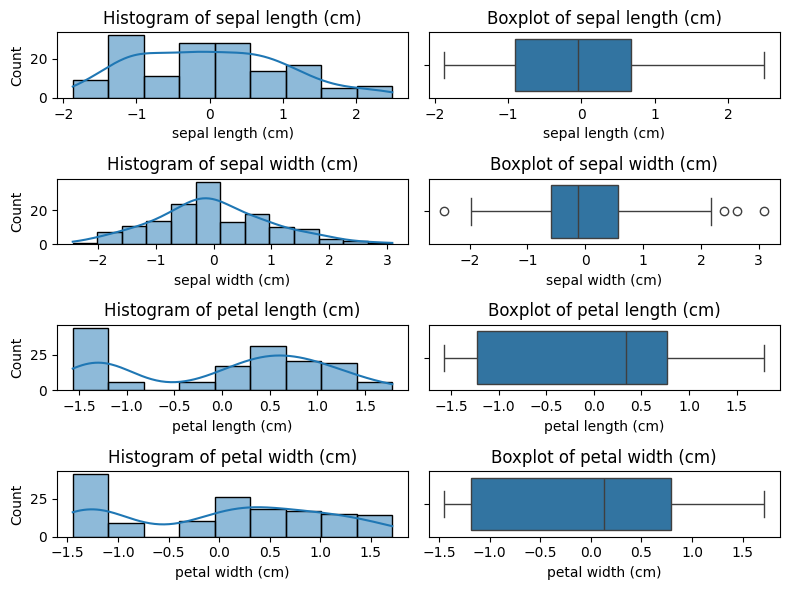

In [12]:
plot_feature_statistics(X_tr, X.columns, line=False)

Conclusion: The shape/distribution of the data is stays the same but the mean and standard deviation changes.

<Axes: ylabel='Density'>

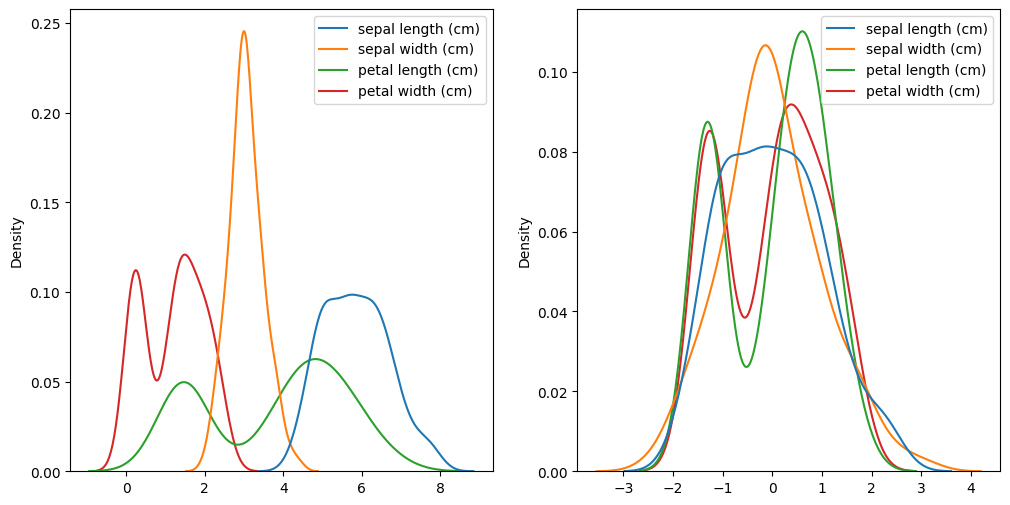

In [13]:
# original kde plot vs post scaler kde plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(data=X, ax=ax[0])
sns.kdeplot(data=X_tr, ax=ax[1])

## Cross Validation Visualizations

- KFold splits data into k consecutive folds (without shuffling by default)...can result in imbalanced class distribution folds
- StratifiedKFold does stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [14]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes at the end
    ax.scatter(range(len(X)), [n_splits + 0.5] * len(X), c=y, marker="_", lw=lw)

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

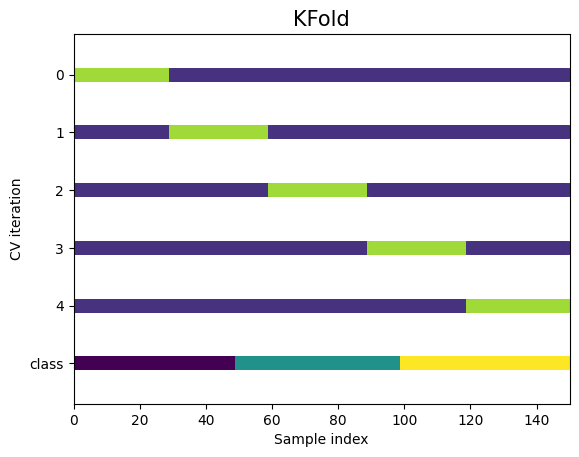

In [15]:
n_splits = 5  # this is the k in k-fold
fig, ax = plt.subplots()
cv = KFold(n_splits=n_splits)
plot_cv_indices(cv, X, y, ax, n_splits=cv.get_n_splits(), lw=10)
plt.show()

So, in iteration 0, samples 0-20 are witheld for testing, in iteration 1, samples...etc.

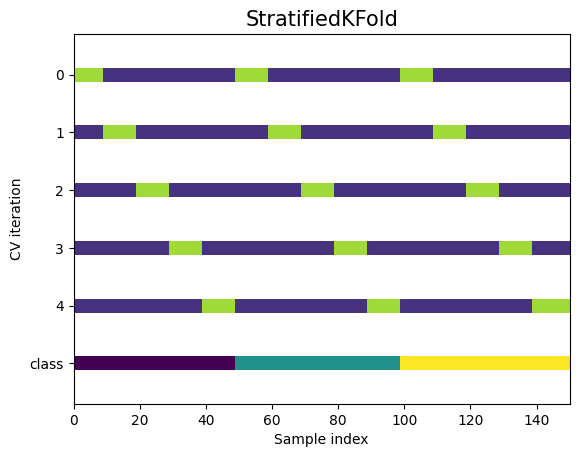

In [16]:
n_splits = 5
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits=n_splits)
plot_cv_indices(cv, X, y, ax, n_splits=cv.get_n_splits(), lw=10)
plt.show()

But with stratified k-fold a portion of each class get witheld for testing at each iteration.

## Is cv1 the same as cv2? 

Meaning, if I use cv1 in one experiment and cv2 in another since they are both StratifiedKFold and n_splits is 3 will they split my data exactly the same?

In [21]:
cv1 = StratifiedKFold(
    n_splits=3,
)

cv2 = StratifiedKFold(
    n_splits=3,
)

In [22]:
cv1

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [23]:
# is cv1 == cv2?

for (tr1, tt1), (tr2, tt2) in zip(cv1.split(X, y), cv2.split(X, y)):
    print(tr1, tr2)
    print(tt1, tt2)
    print(f"tr1 == tr2: {np.array_equal(tr1, tr2)}")

[ 17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149] [ 17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66 100 101
 102 103 104 105 106 107 108 109 110 111